In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from itertools import combinations
from sklearn.model_selection import train_test_split    
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import svm
pd.options.display.max_columns=100
from sklearn.cluster import KMeans

In [2]:
def countryfinder(df1,x):
    return pd.concat([df1[df1['Country_x'].str.contains(x)],df1[df1['Country_y'].str.contains(x)]])
# quality of life indicators
cpi = pd.read_csv('cpi.csv')
cpi = cpi[['Country','2015 cpi']]
cpi = cpi.replace('-',np.nan)
cpi['2015 cpi'] = [float(x) for x in cpi['2015 cpi']]
edbi = pd.read_csv('edbiscores.csv')
edbi=edbi.replace('Russian Federation','Russia')
homicide = pd.read_csv('homicide.csv')
pfi = pd.read_csv('pfi.csv')[['Country','Score']]
pfi.columns = ['Country','2018 pfi']
pfi['2018 pfi'] = [float(x) for x in pfi['2018 pfi']]
homicide.columns = ['Country','Region','Subregion','Homicide Rate','Homicide County','Year','Source']
qol = pd.merge(cpi,pfi,on='Country',how='outer')
qol = pd.merge(qol,edbi,on='Country',how='outer')
qol = pd.merge(qol, homicide, on='Country',how='outer')
qol['score'] = qol['2015 cpi'] / qol['2018 pfi'] * qol['DB 2019']
#GDP and Population
data = pd.read_csv('world_indicators_all_years.csv')
data = data[data['Time'] == '2016']
data = data.replace('Iran, Islamic Rep.','Iran').replace('Korea, Dem. People’s Rep.',"North Korea").replace('Lao PDR','Laos').replace('Korea, Rep.','South Korea').replace('Macedonia, FYR','Macedonia').replace('Myanmar','Myanmar (Burma)').replace('Russian Federation','Russia').replace('Slovak Republic','Slovakia').replace('Syrian Arab Republic','Syria').replace('Venezuela, RB','Venezuela').replace('Yemen, Rep.','Yemen')
data1 = data[['Country Name', 'Population, total [SP.POP.TOTL]','Population growth (annual %) [SP.POP.GROW]','GDP (current US$) [NY.GDP.MKTP.CD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]']]
data1 = data1.replace('..',np.nan)
for x in [*data1.columns][1:]:
    data1[x] = [float(i) for i in data1[x]]
data1['Population, total [SP.POP.TOTL]'] = [float(n) for n in data1['Population, total [SP.POP.TOTL]']]
data1 = pd.merge(qol,data1,left_on='Country',right_on='Country Name',how='outer')
#trust=pd.read_csv('self-reported-trust-attitudes.csv')
#trust=trust[trust['Year']==2014]
#data1=pd.merge(data1,trust,left_on='Country',right_on='Entity').drop(['Entity','Code','Year_y'],1)
#treaties
schengen = ['Austria','Belgium','Czech Republic','Denmark','Estonia','Finland','France','Germany','Greece','Hungary','Iceland','Italy','Latvia','Liechtenstein','Lithuania','Luxembourg','Malta','Netherlands','Monaco','Norway','Poland','Portugal','San Marino','Slovakia','Slovenia','Spain','Sweden','Switzerland','Vatican City']
common = ['Ireland','United Kingdom']
unionstate = ['Russia','Belarus']
peaceandfriendship = ['India','Bhutan','Nepal']
ca4 = ['El Salvador','Honduras','Guatemala','Nicaragua']
tasman = ['Australia','New Zealand']
andean = ['Bolivia','Ecuador','Colombia','Peru']
caricom = ['Antigua and Barbuda','Barbados', 'Belize', 'Dominica', 'Grenada','Guyana','Jamaica','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Suriname','Trinidad and Tobago']
gcc = ['Saudi Arabia','Oman','Kuwait','United Arab Emirates','Bahrain']
eac = ['Kenya','Tanzania','Uganda','South Sudan','Rwanda','Burundi']
table = [schengen+common+unionstate+peaceandfriendship+ca4+tasman+andean+caricom+gcc+eac,['Schengen'] * len(schengen) + ['Common'] * len(common) + ['Union State'] * len(unionstate) + ['Peace and Friendship'] * len(peaceandfriendship) + ['Central America 4'] * len(ca4) + ['Trans-Tasman Agreement'] * len(tasman) + ['Andean Community'] * len(andean) + len(caricom) * ['Caricom'] + len(gcc) * ['Gulf Cooperation Council'] + ['East African Community'] * len(eac)]
treaties = pd.DataFrame(table).transpose()
treaties.columns = ['Country','Treaty']
notreaty = pd.DataFrame([*set(treaties['Country'])^set(data1['Country Name'])])
notreaty['Treaty'] = None
notreaty.columns = ['Country','Treaty']
treaties = pd.concat([notreaty,treaties])
data1 = pd.merge(data1,treaties,how='outer')
#Democracy Index from the EIU
democracy=pd.read_csv('democracyindex2019.csv')
democracy.columns=['Rank', 'Country', 'Democracy Score', 'Electoral process and pluralism',
       'Functioning of government', 'Political participation',
       'Political culture', 'Civil liberties', 'Regime type', 'Region[n 1]',
       'Changes from last year']
data1=pd.merge(data1,democracy,on='Country',how='outer')
#bring it all together
gini=pd.read_csv('gini.csv').iloc[:217].replace('..',np.nan)
data1['gini']=gini[['1990 [YR1990]', '2000 [YR2000]', '2010 [YR2010]', '2011 [YR2011]',
       '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]',
       '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]']].astype(float).mean(axis=1)
combos=list(combinations(data1['Country'],2))
borders=pd.DataFrame(combos).drop_duplicates()
test2=pd.merge(pd.merge(borders,data1.drop('Rank',1),left_on=0,right_on='Country Name',how='inner'),data1.drop('Rank',1),left_on=1,right_on='Country Name',how='inner')
#More statistics
test2.columns = ['Country_x', 'Country_y', 'C', '2015 cpi_x', '2018 pfi_x', 'DB_y018_x',
       'DB_y019_x', 'Region_x', 'Subregion_x', 'Homicide Rate_x',
       'Homicide County_x', 'Year_x', 'Source_x', 'score_x', 'Country Name_x',
       'Population_x',
       'Population growth_x',
       'GDP_x',
       'GDP per capita_x', 'Treaty_x',
       'Democracy Score_x', 'Electoral process and pluralism_x',
       'Functioning of government_x', 'Political participation_x',
       'Political culture_x', 'Civil liberties_x', 'Regime type_x',
       'Region[n_x]_x', 'Changes from last year_x', 'gini_x', 'Country',
       '2015 cpi_y', '2018 pfi_y', 'DB_y018_y', 'DB_y019_y', 'Region_y',
       'Subregion_y', 'Homicide Rate_y', 'Homicide County_y', 'Year_y',
       'Source_y', 'score_y', 'Country Name_y',
       'Population_y',
       'Population growth_y',
       'GDP_y',
       'GDP per capita_y', 'Treaty_y',
       'Democracy Score_y', 'Electoral process and pluralism_y',
       'Functioning of government_y', 'Political participation_y',
       'Political culture_y', 'Civil liberties_y', 'Regime type_y',
       'Region[n_x]_y', 'Changes from last year_y', 'gini_y']
test2['Population difference'] = test2['Population_x'] / test2['Population_y']
test2['Population growth difference'] = test2['Population growth_x']/ test2['Population growth_y']
test2['GDP difference'] = test2['GDP_x'] / test2['GDP_y']
test2['GDP per capita difference'] = test2['GDP per capita_x'] / test2['GDP per capita_y']
test2['Democracy Score difference']=test2['Democracy Score_x']/test2['Democracy Score_y']
test2['Electoral process and pluralism difference']=test2['Electoral process and pluralism_x']/test2['Electoral process and pluralism_y']
test2['Functioning of government difference']=test2['Functioning of government_x']/test2['Functioning of government_y']
test2['Political participation difference']=test2['Political participation_x']/test2['Political participation_y']
test2['Population difference'] = [1/x if x> 1 else x for x in test2['Population difference'] ]
test2['Population growth difference'] = [1/x if x> 1 else x for x in test2['Population growth difference']]
test2['GDP difference'] = [1/x if x> 1 else x for x in test2['GDP difference']]
test2['GDP per capita difference'] = [1/x if x> 1 else x for x in test2['GDP per capita difference']]
#test2 = pd.merge(test2,df2, left_on='Country_x', right_on='Name of country',how='outer').drop('Borders',1)
test2['GDP product'] = test2['GDP_x'] *test2['GDP_y']
test2['GDP per capita in both'] = (test2['GDP_x'] + test2['GDP_y']) / (test2['Population_x'] + test2['Population_y'])
test2 = test2.drop_duplicates('GDP product').reset_index()
df1 = test2
df1['cpi difference'] = df1['2015 cpi_x'] / df1['2015 cpi_y']
#df1['cpi difference'] = [1/x if x> 1 for x in df1['cpi difference'] else x]
df1['GDP sum'] = df1['GDP_x']+df1['GDP_y']
df1['cpi difference'] = [1/x if x> 1 else x for x in df1['cpi difference']]
df1['db difference'] = df1['DB_y019_x'] / df1['DB_y019_y']
df1['db difference'] = [1/x if x> 1 else x for x in df1['db difference']]
df1['pfi difference'] = df1['2018 pfi_x'] / df1['2018 pfi_y']
df1['pfi difference'] = [1/x if x> 1 else x for x in df1['pfi difference']]
df1['homicide difference'] = df1['Homicide Rate_x'] / df1['Homicide Rate_y']
df1['homicide difference'] = [1/x if x> 1 else x for x in df1['homicide difference']]
#df1['trust difference'] = df1['trust1'] / df1['trust2']
#df1['trust difference'] = [1/x if x> 1 else x for x in df1['pfi difference']]
df1['Country Similarity'] = (df1['cpi difference']+df1['db difference']+df1['pfi difference']+df1['homicide difference']) /4
df1['average cpi'] = df1[['2015 cpi_x','2015 cpi_y']].mean(axis=1)
df1['average db'] = df1[['DB_y019_x','DB_y019_y']].mean(axis=1)
df1['average pfi'] = df1[['2018 pfi_x','2018 pfi_y']].mean(axis=1)
df1['average homicide'] = df1[['Homicide Rate_x','Homicide Rate_y']].mean(axis=1)
df1['average Democracy Score']=df1[['Democracy Score_x','Democracy Score_y']].mean(axis=1)
df1['average Electoral process and pluralism']=df1[['Electoral process and pluralism_x','Electoral process and pluralism_y']].mean(axis=1)
df1['average Functioning of Government']=df1[['Functioning of government_x','Functioning of government_y']].mean(axis=1)
df1['average Political participation']=df1[['Political participation_x','Political participation_y']].mean(axis=1)
df1['average Civil Liberties']=df1['Civil liberties_x']/df1['Civil liberties_y']
#df1['average trust'] = df1[['trust1','trust2']].mean(axis=1)
df1['Border Status'] = np.where(df1['Treaty_x'] == df1['Treaty_y'], 'Open', 'Closed')
df1['Combined Population'] = df1['Population_x'] + df1['Population_y']
df1['GDP per capita']=df1['GDP sum']/df1['Combined Population']
df1['viability'] = df1['average cpi'] * df1['average db'] / (df1['average pfi'] * df1['average homicide'])
df1['viability2'] = df1['average cpi'] * df1['average db'] *df1['GDP per capita']/ (df1['average pfi'] * df1['average homicide'])
df1 = df1.drop_duplicates('Combined Population').sort_values('viability', ascending = False).reset_index().drop('index',1)
df1['Status']=df1['Border Status'].replace('Open',1).replace('Closed',0)
df1=df1.replace(np.inf,np.nan)
df1['Same Region']=df1['Region_x']==df1['Region_y']
df1['Same Subregion']=df1['Subregion_x']==df1['Subregion_y']
df1['Same Region']=df1['Same Region'].replace(False,0)
df1['Same Subregion']=df1['Same Subregion'].replace(False,0)
df1=df1.dropna(subset=['Country_x','Country_y','2018 pfi_x','2018 pfi_y','GDP_x','GDP_y','GDP per capita_x','GDP per capita_y','2015 cpi_x','2015 cpi_y','DB_y018_x','DB_y018_y','Homicide Rate_x','Homicide Rate_y','Democracy Score_x','Democracy Score_y','Status'])[['Country_x','Country_y','GDP_x','GDP_y','GDP per capita_x','GDP per capita_y','2015 cpi_x','2015 cpi_y','DB_y018_x','DB_y018_y','Homicide Rate_x','Homicide Rate_y','Democracy Score_x','Democracy Score_y','Population_x','Population_y','2018 pfi_x','2018 pfi_y','Status','Same Region','Same Subregion']]
for x in ['2015 cpi','DB_y018','2018 pfi','Homicide Rate','Democracy Score','Population']:
    df1['Average '+x]=df1[[x+'_x',x+'_y']].mean(axis=1)
df1['Population']=df1['Population_x']+df1['Population_y']
df1['GDP']=df1['GDP_x']+df1['GDP_y']
df1['GDP per capita']=df1['GDP']/df1['Population']
df1['worse cpi']=df1[['2015 cpi_y','2015 cpi_x']].min(axis=1)
df1['worse pfi']=df1[['2018 pfi_x','2018 pfi_y']].max(axis=1)
df1['worse DB']=df1[['DB_y018_y','DB_y018_x']].min(axis=1)
df1['worse homicide']=df1[['Homicide Rate_y','Homicide Rate_x']].max(axis=1)
df1['worse GDP per capita']=df1[['GDP per capita_y','GDP per capita_x']].min(axis=1)
df1['better cpi']=df1[['2015 cpi_y','2015 cpi_x']].max(axis=1)
df1['better pfi']=df1[['2018 pfi_x','2018 pfi_y']].min(axis=1)
df1['better DB']=df1[['DB_y018_y','DB_y018_x']].max(axis=1)
df1['better homicide']=df1[['Homicide Rate_y','Homicide Rate_x']].min(axis=1)
df1['better GDP per capita']=df1[['GDP per capita_y','GDP per capita_x']].max(axis=1)
df1['worse Democracy Score']=df1[['Democracy Score_y','Democracy Score_x']].min(axis=1)
df1['better Democracy Score']=df1[['Democracy Score_y','Democracy Score_x']].max(axis=1)
df1['keep']=df1['Country_x']==df1['Country_y']
df1=df1[df1['keep']==False]
df1=df1.drop('keep',1)
data2=data1.dropna(subset=['Country','Population, total [SP.POP.TOTL]'])[~data1['Country'].isin(['Guam','South Asia','American Samoa','Europe & Central Asia','East Asia & Pacific','Middle East & North Africa','Latin America & Caribbean','Sub-Saharan Africa'])].drop_duplicates('Country').sort_values('Population, total [SP.POP.TOTL]',ascending=False).reset_index(drop=True)
df1

/home/matthew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:162: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Country_x    Country_y         GDP_x         GDP_y  GDP per capita_x  \
68         Iceland       Norway  2.004741e+10  3.710762e+11      59976.942565   
116    Netherlands       Norway  7.772275e+11  3.710762e+11      45669.814802   
123         Norway  Switzerland  3.710762e+11  6.688513e+11      70911.757159   
140        Iceland  Netherlands  2.004741e+10  7.772275e+11      59976.942565   
189        Iceland  Switzerland  2.004741e+10  6.688513e+11      59976.942565   
...            ...          ...           ...           ...               ...   
22735  El Salvador     Honduras  2.679747e+10  2.151694e+10       4223.584579   
22748  El Salvador         Iraq  2.679747e+10  1.714890e+11       4223.584579   
22759     Honduras         Iraq  2.151694e+10  1.714890e+11       2361.160205   
22812  El Salvador        Sudan  2.679747e+10  9.558438e+10       4223.584579   
22819     Honduras        Sudan  2.151694e+10  9.558438e+10       2361.160205   

       GDP per capita_y  2015 cpi_x  2015 cpi_y  DB_y018_x  DB_y018_y  \
68         70911.757159        79.0        87.0      79.30      82.70   
116        70911.757159        87.0        87.0      76.03      82.70   
123        79890.524005        87.0        86.0      82.70      75.68   
140        45669.814802        79.0        87.0      79.30      76.03   
189        79890.524005        79.0        86.0      79.30      75.68   
...                 ...         ...         ...        ...        ...   
22735       2361.160205        39.0        31.0      65.20      58.13   
22748       4609.600694        39.0        16.0      65.20      44.68   
22759       4609.600694        31.0        16.0      58.13      44.68   
22812       2415.038162        39.0        12.0      65.20      45.09   
22819       2415.038162        31.0        12.0      58.13      45.09   

       Homicide Rate_x  Homicide Rate_y  Democracy Score_x  Democracy Score_y  \
68                0.30             0.51               9.58               9.87   
116               0.55             0.51               9.01               9.87   
123               0.51             0.54               9.87               9.03   
140               0.30             0.55               9.58               9.01   
189               0.30             0.54               9.58               9.03   
...                ...              ...                ...                ...   
22735            82.84            56.52               6.15               5.42   
22748            82.84             9.85               6.15               3.74   
22759            56.52             9.85               5.42               3.74   
22812            82.84             5.16               6.15               2.70   
22819            56.52             5.16               5.42               2.70   

       Population_x  Population_y  2018 pfi_x  2018 pfi_y  Status  \
68         334252.0     5232929.0       14.10        7.63       1   
116      17018408.0     5232929.0       10.01        7.63       1   
123       5232929.0     8372098.0        7.63       11.27       1   
140        334252.0    17018408.0       14.10       10.01       1   
189        334252.0     8372098.0       14.10       11.27       1   
...             ...           ...         ...         ...     ...   
22735     6344722.0     9112867.0       27.78       45.23       1   
22748     6344722.0    37202572.0       27.78       56.56       0   
22759     9112867.0    37202572.0       45.23       56.56       0   
22812     6344722.0    39578828.0       27.78       71.13       0   
22819     9112867.0    39578828.0       45.23       71.13       0   

       Same Region  Same Subregion  Average 2015 cpi  Average DB_y018  \
68             1.0             1.0              83.0           81.000   
116            1.0             0.0              87.0           79.365   
123            1.0             0.0              86.5           79.190   
140            1.0             0.0              83.0           77

In [3]:
americas=['Canada','United States','Mexico','Guatemala','Belize','Honduras','Costa Rica','Panama','Colombia','Venezuela','Ecuador','Peru','Brazil','Bolivia','Argentina','Uruguay','Chile']
europe=['United Kingdom','Ireland','France','Spain','Portugal','Italy','Switzerland','Germany','Belgium','Netherlands','Austria','Czechia','Poland','Hungary','Romania','Greece','Turkey','Russia','Finland','Norway','Sweden','Denmark','Iceland']
asia=['Turkey','Syria','Israel','Jordan','Saudi Arabia','Yemen','Oman','United Arab Emirates','Turkmenistan','Uzbekistan','China','Mongolia','Japan','Vietnam','Laos','Cambodia','Thailand','Myanmar','India','Nepal','Bhutan','Sri Lanka','Philippines','Malaysia','Singapore','Indonesia','Papua New Guinea','Australia','New Zealand','Fiji','Samoa','Micronesia','Tonga','Hong Kong SAR, China']
africa=['Morocco','Tunisia','Egypt','Mali','Ethiopia','Kenya','Uganda','Tanzania','Malawi','Zambia','Zimbabwe','Botswana','Namibia','South Africa','Madagascar']
caribbean=['Antigua and Barbuda','Bahamas','Barbados','Cuba','Dominica','Dominican Republic','Grenada','St. Vincent and the Grenadines','Jamaica','St. Kitts and Nevis','St. Lucia','Trinidad and Tobago']
targets=americas+europe+asia+africa+caribbean

In [4]:
missing=data1[~data1['Country Name'].isin(targets)].sort_values('GDP per capita (current US$) [NY.GDP.PCAP.CD]',ascending=False).dropna(subset=['Country']).drop_duplicates(subset=['Country'])
included=data1[data1['Country Name'].isin(targets)].sort_values('GDP per capita (current US$) [NY.GDP.PCAP.CD]',ascending=False).dropna(subset=['Country']).drop_duplicates(subset=['Country'])

In [5]:
missing[(missing['2015 cpi']>70)&(missing['Population, total [SP.POP.TOTL]']>10**6)]

Country  2015 cpi  2018 pfi  DB 2018  DB 2019 Region     Subregion  \
164   Qatar      71.0     40.16    65.25    65.89   Asia  Western Asia   

     Homicide Rate  Homicide County    Year    Source       score  \
164           0.38              9.0  2014.0  UNSDC/MD  116.488795   

    Country Name  Population, total [SP.POP.TOTL]  \
164        Qatar                        2569804.0   

     Population growth (annual %) [SP.POP.GROW]  \
164                                     3.49507   

     GDP (current US$) [NY.GDP.MKTP.CD]  \
164                        1.524519e+11   

     GDP per capita (current US$) [NY.GDP.PCAP.CD] Treaty   Rank  \
164                                   59324.338773   None  128.0   

     Democracy Score  Electoral process and pluralism  \
164             3.19                              0.0   

     Functioning of government  Political participation  Political culture  \
164                       4.29                     2.22               5.63   

     Civil liberties    Regime type                 Region[n 1]  \
164             3.82  Authoritarian  Middle East & North Africa   

    Changes from last year  gini  
164      Score: \nRank:  5   NaN

In [6]:
missing['status']=0
included['status']=1
df=pd.concat([missing,included])

In [7]:
df.columns=['Country', '2015 cpi', '2018 pfi', 'DB 2018', 'DB 2019', 'Region',
       'Subregion', 'Homicide Rate', 'Homicide County', 'Year', 'Source',
       'score', 'Country Name', 'Population',
       'Population growth',
       'GDP',
       'GDP per capita', 'Treaty', 'Rank',
       'Democracy Score', 'Electoral process and pluralism',
       'Functioning of government', 'Political participation',
       'Political culture', 'Civil liberties', 'Regime type', 'Region[n 1]',
       'Changes from last year', 'gini', 'status']

In [8]:
px.scatter(df,x='GDP per capita',y='Democracy Score',color='status',hover_data=['Country'],color_continuous_scale=px.colors.sequential.Bluered_r)

In [18]:
px.scatter(df[df['Region']!='Europe'],x='GDP per capita',y='Democracy Score',color='status',hover_data=['Country'],color_continuous_scale=px.colors.sequential.Bluered_r)

In [9]:
px.scatter(df[df['Population']>10**6],x='GDP per capita',y='Democracy Score',color='status',hover_data=['Country'],color_continuous_scale=px.colors.sequential.Bluered_r)

In [29]:
list(df[(df['Region']=='Europe')&(df['Democracy Score']>7)&(df['GDP per capita']>20000)].sort_values('Country')['Country'])

['Austria',
 'Belgium',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Iceland',
 'Ireland',
 'Italy',
 'Luxembourg',
 'Malta',
 'Netherlands',
 'Norway',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'United Kingdom']

In [10]:
def RFRegressor(y, df):
    df=df.select_dtypes(include=np.number).dropna()
    X = df.drop([y], 1)
    y = df[y]
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor()
    rf.fit(X, y)
    names = X.dtypes.index
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
                 reverse=True))
RFRegressor('status',df)

Features sorted by their score:
[(0.1681, 'Functioning of government'), (0.1631, 'Population'), (0.141, 'GDP'), (0.0929, 'gini'), (0.0771, 'Population growth'), (0.0673, 'DB 2018'), (0.0367, '2015 cpi'), (0.0356, 'Homicide Rate'), (0.03, 'Homicide County'), (0.0295, 'Political culture'), (0.0278, 'score'), (0.0239, 'DB 2019'), (0.0233, 'Rank'), (0.016, '2018 pfi'), (0.0141, 'Civil liberties'), (0.014, 'Democracy Score'), (0.0133, 'Electoral process and pluralism'), (0.0108, 'GDP per capita'), (0.0089, 'Political participation'), (0.0066, 'Year')]


In [11]:
px.scatter(df,x='GDP',y='Functioning of government',color='status',hover_data=['Country'],color_continuous_scale=px.colors.sequential.Bluered_r)

In [12]:
px.scatter(df[df['GDP']>10**12],x='GDP',y='Functioning of government',color='status',hover_data=['Country'],color_continuous_scale=px.colors.sequential.Bluered_r)

In [13]:
 def decisiontree(df, y):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.model_selection import train_test_split
    df=df.select_dtypes(include=np.number).dropna()
    X = df.drop([y],1)
    y = df[y]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
    clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [14]:
decisiontree(df,'status')

0.7368421052631579

In [15]:
def regression(df, y):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    df=df.select_dtypes(include=np.number).dropna()
    X = df.drop([y],1)
    y = df[y]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
    model = sm.OLS(y_train, X_train)
    model = model.fit()
    predictions = model.predict(X_test)
    # Plot the model
    plt.figure(figsize=(8,6))
    plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
    plt.xlabel("Predicted Values - $\hat{y}$")
    plt.ylabel("Actual Values - $y$")
    plt.show()
    print("MSE:", mean_squared_error(y_test, predictions))
    return model.summary()

findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


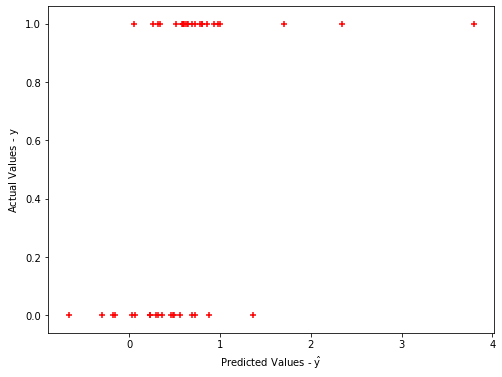

MSE: 0.4532470033089446


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 status   R-squared (uncentered):                   0.817
Model:                            OLS   Adj. R-squared (uncentered):              0.708
Method:                 Least Squares   F-statistic:                              7.529
Date:                Tue, 29 Dec 2020   Prob (F-statistic):                    2.87e-06
Time:                        21:09:42   Log-Likelihood:                         -13.695
No. Observations:                  43   AIC:                                      59.39
Df Residuals:                      27   BIC:                                      87.57
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
2015 cpi                           -0.0088      0.009     -0.973      0.339      -0.027       0.010
2018 pfi                            0.0027      0.010      0.272      0.788      -0.018       0.023
DB 2018                             0.1677      0.081      2.072      0.048       0.002       0.334
DB 2019                            -0.1549      0.075     -2.052      0.050      -0.310   -3.97e-05
Homicide Rate                      -0.0044      0.006     -0.787      0.438      -0.016       0.007
Homicide County                  3.456e-05   3.09e-05      1.120      0.273   -2.88e-05    9.79e-05
Population                           2e-09   2.14e-09      0.934      0.359    -2.4e-09     6.4e-09
Population growth                   0.1934      0.087      2.232      0.034       0.016       0.371
GDP                              2.145e-14   1.23e-13      0.174      0.863   -2.31e-13    2.74e-13
GDP per capita                    6.27e-06   9.08e-06      0.691      0.496   -1.24e-05    2.49e-05
Democracy Score                    -3.9153     27.029     -0.145      0.886     -59.373      51.543
Electoral process and pluralism     0.7775      5.406      0.144      0.887     -10.314      11.869
Functioning of government           0.9468      5.412      0.175      0.862     -10.158      12.052
Political participation             0.6742      5.405      0.125      0.902     -10.416      11.764
Political culture                   0.7405      5.391      0.137      0.892     -10.322      11.803
Civil liberties                     0.8069      5.413      0.149      0.883     -10.300      11.914
gini                               -0.0098      0.010     -0.964      0.344      -0.031       0.011
==============================================================================
Omnibus:                        1.155   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                1.033
Skew:                          -0.362   Prob(JB):                        0.597
Kurtosis:                       2.771   Cond. No.                     3.65e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.65e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
regression(df.drop(['Year','score','Rank'],1),'status')

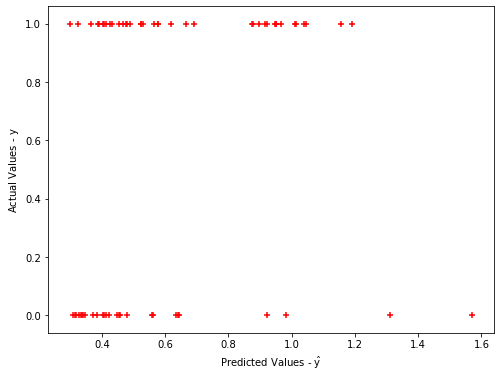

MSE: 0.2640871204268826


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 status   R-squared (uncentered):                   0.676
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              17.62
Date:                Tue, 29 Dec 2020   Prob (F-statistic):                    2.24e-12
Time:                        21:09:42   Log-Likelihood:                         -36.407
No. Observations:                  66   AIC:                                      86.81
Df Residuals:                      59   BIC:                                      102.1
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
DB 2018            -0.0013      0.007     -0.187      0.853      -0.015       0.013
2015 cpi            0.0066      0.006      1.042      0.302      -0.006       0.019
2018 pfi            0.0018      0.005      0.332      0.741      -0.009       0.013
Homicide Rate       0.0147      0.007      2.045      0.045       0.000       0.029
Population       5.599e-10   3.51e-10      1.593      0.116   -1.43e-10    1.26e-09
GDP per capita   6.859e-06   6.03e-06      1.137      0.260   -5.21e-06    1.89e-05
Democracy Score     0.0152      0.045      0.335      0.739      -0.076       0.106
==============================================================================
Omnibus:                       34.367   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.639
Skew:                           0.248   Prob(JB):                       0.0596
Kurtosis:                       1.657   Cond. No.                     1.50e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
regression(df[['Country','DB 2018','2015 cpi','2018 pfi','Homicide Rate','Population','GDP per capita','Democracy Score','status']],'status')

In [34]:
print(list(df[(df['Democracy Score']>7)&(df['GDP per capita']>20000)].sort_values('Country')['Country']))

['Australia', 'Austria', 'Belgium', 'Canada', 'Cyprus', 'Denmark', 'Finland', 'France', 'Germany', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Slovenia', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'United States']
